In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D,BatchNormalization,UpSampling1D,Conv1DTranspose,Dense,Flatten
from tensorflow.keras.models import Sequential,Model
from mat4py import loadmat
from keras.layers import LSTM
from tensorflow.keras.optimizers import Adam,SGD
import scipy.io
from math import log10, sqrt
from keras import backend as K
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import LSTM, Input, Dropout
from sklearn.linear_model import LinearRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import random

In [21]:
mat = scipy.io.loadmat('100m.mat')

In [22]:
def augment_ecg(ecg_signal):
    """
    Perform data augmentation on the ECG signal
    """
    # Add random noise to the signal
    noise_augmenter = AddNoise(random_state=42)
    noisy_ecg = noise_augmenter.transform(ecg_signal.reshape(1, -1))[0]

    # Apply random window cropping to the signal
    window_augmenter = RandomWindow(window_size=0.1, random_state=42)
    cropped_ecg = window_augmenter.transform(ecg_signal.reshape(1, -1))[0]

    # Stack the original signal, noisy signal, and cropped signal together
    augmented_ecg = np.vstack((ecg_signal, noisy_ecg, cropped_ecg))

    return augmented_ecg

In [23]:
def normalize_ecg(ecg_signal):
    """
    Normalize the ECG signal using min-max normalization
    """
    # Find the minimum and maximum values of the signal
    min_val = np.min(ecg_signal)
    max_val = np.max(ecg_signal)

    # Normalize the signal using min-max normalization
    normalized_ecg = (ecg_signal - min_val) / (max_val - min_val)

    return normalized_ecg

In [24]:
mat

{'__header__': b'MATLAB 5.0',
 '__version__': '1.0',
 '__globals__': [],
 'val': array([[ -29,  -29,  -29, ..., -135, -153, -256],
        [ -13,  -13,  -13, ...,  -73,  -67,    0]], dtype=int16)}

mat

In [25]:
aa=mat['val']
a=aa[0,0:]
aa5=a[0:200000]
aa1=normalize_ecg(aa5)
aa2=len(aa1)/2000
aa6=int(aa2)*2000
aa4=aa1[0:int(aa6)]
data=aa4.reshape(int(aa2),2000)
data.shape

(100, 2000)

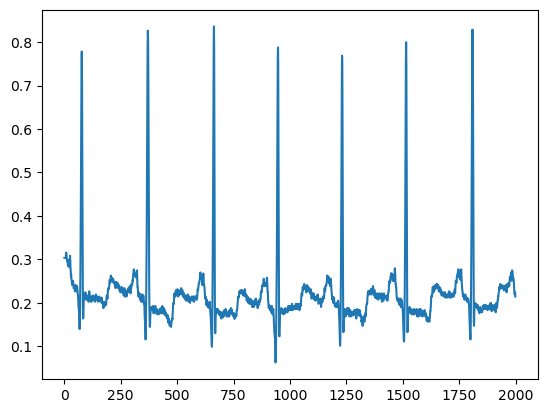

In [26]:
plt.plot(data[0])

In [27]:
X_train, X_test = train_test_split(data, test_size=0.2)
X_train.shape

(80, 2000)

In [28]:
model=Sequential()
model.add(Conv1D(8,3,activation='relu',padding='same',input_shape = (2000,1)))

model.add(MaxPooling1D(2))
model.add(Conv1D(32,5,activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Conv1D(16,3,activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Conv1D(64,11,activation='relu',padding='same'))
model.add(Conv1D(128,13,activation='relu',padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(32,3,activation='relu',padding='same'))
model.add(Conv1D(1,7,activation='relu',padding='same'))
model.add(MaxPooling1D(2))

# #decoder
model.add(Conv1DTranspose(1,7,activation='relu',padding='same'))
model.add(Conv1DTranspose(32,3,activation='relu',padding='same'))
model.add(UpSampling1D(2))
model.add(Conv1DTranspose(64,11,activation='relu',padding='same'))
model.add(Conv1DTranspose(128,13,activation='relu',padding='same'))
model.add(UpSampling1D(2))
model.add(Conv1DTranspose(16,3,activation='relu',padding='same'))
model.add(Conv1DTranspose(32,5,activation='relu',padding='same'))
model.add(UpSampling1D(2))
model.add(Conv1DTranspose(32,3,activation='relu',padding='same'))
model.add(UpSampling1D(2))
model.add(Conv1DTranspose(8,3,activation='relu',padding='same'))
model.add(Flatten())
model.add(Dense(2000,activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 2000, 8)           32        
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1000, 8)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 1000, 32)          1312      
                                                                 
 batch_normalization_2 (Batc  (None, 1000, 32)         128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 500, 32)          0         
 1D)                                                             
                                                      

In [29]:
# #parameters_compilation
def root_mean_squared_error(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float32)
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 
#adm= Adam(learning_rate=0.01)
#model.compile(optimizer=adm ,loss=root_mean_squared_error,metrics=["mae", "acc"])
# sgd= SGD(learning_rate=0.01)
#opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss=root_mean_squared_error,metrics=["mae", "acc"])
# model.compile(optimizer='Adam' ,loss='binary_crossentropy',metrics=[ "acc"])

In [47]:
#training
model.fit(X_train,X_train,epochs=200,batch_size=64)

Epoch 1/200
2/2 [==============================] - 1s 395ms/step - loss: 0.0049 - mae: 0.0037 - acc: 0.8750
Epoch 2/200
2/2 [==============================] - 1s 366ms/step - loss: 0.0048 - mae: 0.0037 - acc: 0.8750
Epoch 3/200
2/2 [==============================] - 1s 387ms/step - loss: 0.0057 - mae: 0.0045 - acc: 0.9375
Epoch 4/200
2/2 [==============================] - 1s 284ms/step - loss: 0.0063 - mae: 0.0052 - acc: 0.9125
Epoch 5/200
2/2 [==============================] - 1s 391ms/step - loss: 0.0064 - mae: 0.0053 - acc: 0.8875
Epoch 6/200
2/2 [==============================] - 1s 298ms/step - loss: 0.0052 - mae: 0.0041 - acc: 0.8375
Epoch 7/200
2/2 [==============================] - 1s 334ms/step - loss: 0.0058 - mae: 0.0047 - acc: 0.8875
Epoch 8/200
2/2 [==============================] - 1s 353ms/step - loss: 0.0064 - mae: 0.0053 - acc: 0.9000
Epoch 9/200
2/2 [==============================] - 1s 300ms/step - loss: 0.0068 - mae: 0.0057 - acc: 0.8750
Epoch 10/200
2/2 [==========

2/2 [==============================] - 1s 353ms/step - loss: 0.0057 - mae: 0.0046 - acc: 0.9000
Epoch 77/200
2/2 [==============================] - 1s 344ms/step - loss: 0.0066 - mae: 0.0056 - acc: 0.9125
Epoch 78/200
2/2 [==============================] - 1s 317ms/step - loss: 0.0060 - mae: 0.0048 - acc: 0.9000
Epoch 79/200
2/2 [==============================] - 1s 319ms/step - loss: 0.0055 - mae: 0.0043 - acc: 0.8750
Epoch 80/200
2/2 [==============================] - 1s 325ms/step - loss: 0.0045 - mae: 0.0036 - acc: 0.8750
Epoch 81/200
2/2 [==============================] - 1s 296ms/step - loss: 0.0050 - mae: 0.0036 - acc: 0.9125
Epoch 82/200
2/2 [==============================] - 1s 323ms/step - loss: 0.0043 - mae: 0.0033 - acc: 0.8500
Epoch 83/200
2/2 [==============================] - 1s 308ms/step - loss: 0.0049 - mae: 0.0038 - acc: 0.9125
Epoch 84/200
2/2 [==============================] - 1s 335ms/step - loss: 0.0045 - mae: 0.0035 - acc: 0.9125
Epoch 85/200
2/2 [==============

2/2 [==============================] - 1s 344ms/step - loss: 0.0042 - mae: 0.0033 - acc: 0.9000
Epoch 151/200
2/2 [==============================] - 1s 376ms/step - loss: 0.0041 - mae: 0.0031 - acc: 0.9375
Epoch 152/200
2/2 [==============================] - 1s 371ms/step - loss: 0.0047 - mae: 0.0038 - acc: 0.8750
Epoch 153/200
2/2 [==============================] - 1s 372ms/step - loss: 0.0045 - mae: 0.0036 - acc: 0.9125
Epoch 154/200
2/2 [==============================] - 1s 384ms/step - loss: 0.0047 - mae: 0.0038 - acc: 0.9250
Epoch 155/200
2/2 [==============================] - 1s 366ms/step - loss: 0.0040 - mae: 0.0030 - acc: 0.9125
Epoch 156/200
2/2 [==============================] - 1s 323ms/step - loss: 0.0046 - mae: 0.0035 - acc: 0.8375
Epoch 157/200
2/2 [==============================] - 1s 380ms/step - loss: 0.0067 - mae: 0.0053 - acc: 0.9000
Epoch 158/200
2/2 [==============================] - 1s 330ms/step - loss: 0.0056 - mae: 0.0045 - acc: 0.9000
Epoch 159/200
2/2 [=====

In [44]:
pred=model.predict(X_test)
pred.shape

(20, 2000)

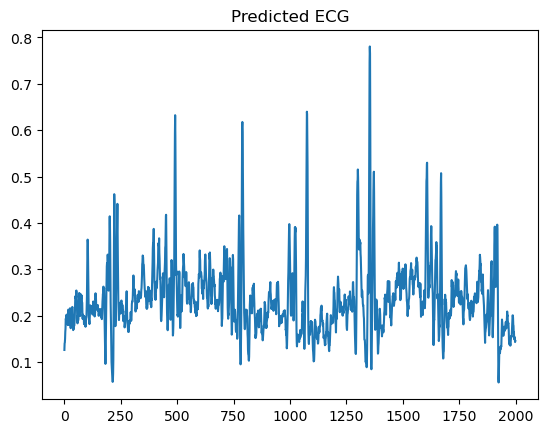

(2000,)


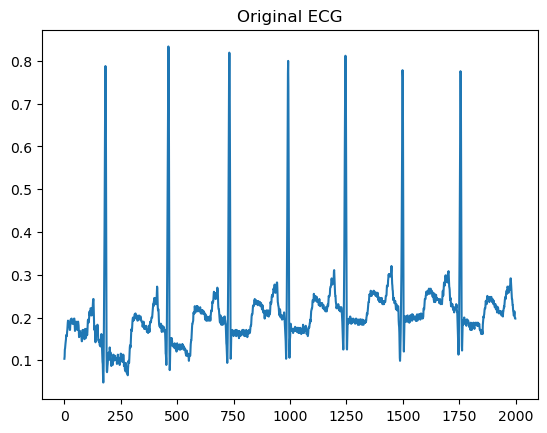

numpy.ndarray

In [45]:
rec1=pred[0,:]
plt.plot(rec1)
plt.title('Predicted ECG')
plt.show()
print(rec1.shape)
xtrn1=X_test[0,:]
plt.plot(xtrn1)
plt.title('Original ECG')
plt.show()
type(rec1)

In [46]:

xtrn1=X_test[0,:]
rec1=pred[0,:]
actual= xtrn1
predicted= rec1
sme= np.sum(np.square(actual - predicted))
org = np.sum(np.square(actual))
prd1= np.sqrt(sme/org)*100
print("PRD:",prd1)

PRD: 37.56945743247265


In [34]:
# scipy.io.savemat('file6.mat', {'ans':rec1})

In [35]:
# scipy.io.savemat('file7.mat', {'ans':xtrn1})

In [36]:
def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))

In [37]:
print("MSE:",mean_squared_error(xtrn1,rec1))

MSE: tf.Tensor(0.00843329130180373, shape=(), dtype=float64)


In [38]:
signal_power = np.sum(actual ** 2) / len(actual)
noise_signal = actual-predicted
noise_power = np.sum(noise_signal ** 2) / len(noise_signal)
snr_db = 10 * np.log10(signal_power / noise_power)
snr_db

7.933112054868198